**Add a markdown cell here that tells the reader what this file is doing, and any setups they may need.** 

I don't really get a good sense of this from just reading the code.

Please clean up commented code a bit. Maybe keep a (uncommited) stash in your own directory, or just kill them and rely on version control (that's why we have git!) to get code that you used to have.

Make the name of this file more useful.


18.338 % of dataset dropped when truncating gas used equal to lower limit of 21000


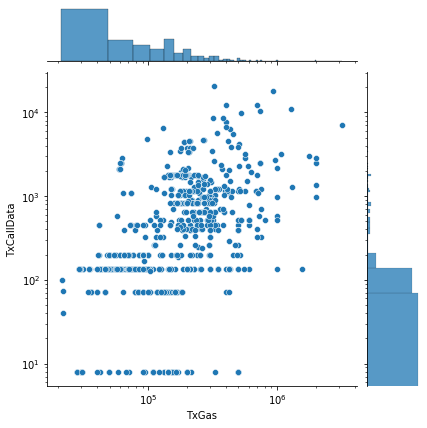

In [4]:
#####  Clean the data and create test and training sets.

# this adds the parent directory into the path, since we want simulations from the parent directory
import sys; sys.path.insert(0, '..')
from settings import DATA_PATH

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
from sklearn.utils import shuffle
import random
from sklearn.linear_model import LinearRegression
import seaborn as sns

data=pd.read_csv(str(DATA_PATH / 'TxF22.csv'))

TxGas=list(data['gas']) #change to gas_used for old data from last year
TxCallData=list(data['input'])
TxCallData=[len(x[2:]) for x in TxCallData] #length of calldata after '0x' string for each entry

#upperLimit=500000 #drop extreme high Tx values
lowerLimitGas=21000 #drop extreme low Tx values
#print(round(100*(1-np.size([x for x in TxGas if x <= upperLimit])/np.size(TxGas)),3), '% of dataset dropped when truncating gas used over upper limit of',upperLimit )
proportionGasLowerLimit=(np.size([x for x in TxGas if x == lowerLimitGas])/np.size(TxGas))
print(round(100*proportionGasLowerLimit,3), '% of dataset dropped when truncating gas used equal to lower limit of',lowerLimitGas )
#lowerLimitCallData=0
#proportionCallDataLowerLimit=np.size([x for x in TxCallData if x == lowerLimitCallData])/np.size(TxCallData)
#print(round(100*proportionCallDataLowerLimit,3), '% of dataset dropped when truncating call data used equal to',lowerLimitCallData )

#Now randomly sample x and 1-x % of Tx to create test and training sets
np.random.seed(10)
(TxGas,TxCallData) = shuffle(TxGas,TxCallData) 
df=pd.DataFrame({'TxGas':TxGas,'TxCallData':TxCallData})
#dfDropZeroCallData = df[df.TxCallData != 0]

jp=sns.jointplot(data=df, x="TxGas", y="TxCallData");
jp.ax_joint.set_xscale('log')
jp.ax_joint.set_yscale('log')

#TxGas=[x for x in TxGas if x <= upperLimit] #drop all over limit
TxGas=[x for x in TxGas if x != lowerLimitGas] #drop all equal to lower limit

#TxCallData=[x for x in TxCallData if x != 0] #drop all call data equal to 0

testSize=20 # % of Txs that will make up test set
TxGasTest=TxGas[0:round(len(TxGas)*testSize/100)]
TxGasTrain=TxGas[round(len(TxGas)*testSize/100):]

TxCallDataTest=TxCallData[0:round(len(TxCallData)*testSize/100)]
TxCallDataTrain=TxCallData[round(len(TxCallData)*testSize/100):]



**Consider splitting your cells.** I'm not sure if this is the best cell to do so, but try to find opportunities to.

Always think: what's the biggest splits I can make such that they can potentially be run separate from each other?

Since sometimes you might just want to data clean, and then run one of the later cells, you don't need to bundle the cleaning and plotting.

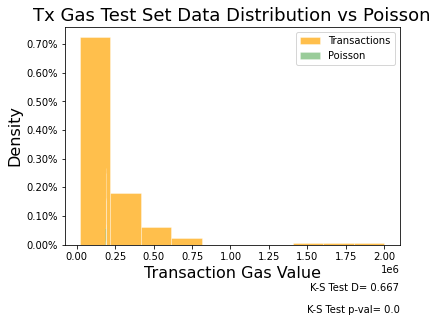

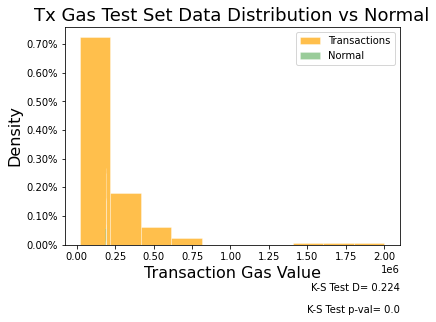

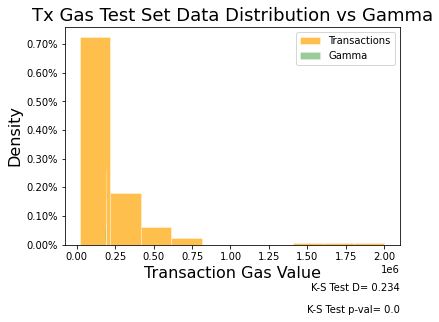

In [5]:
#####  This block fits gas to poisson/normal/gamma, runs K-S tests, and plots histograms  #####



#Tx=poisson(10,200000) #np.array([0,1,1.4,2,4,1,2,4,1,3,6,2,3,6,1,5])


numRVs=np.size(TxGasTrain)
poissGas=stats.poisson.rvs(np.mean(TxGasTrain),size=numRVs) #generate poisson points using estimated lambda from Tx data
norGas=np.random.normal(np.mean(TxGasTrain),np.var(TxGasTrain)**0.5,numRVs)  #generate poisson points using estimated lambda from Tx data

#MoM estimation of gamma distr:
aGas=(np.mean(TxGasTrain))**2/np.var(TxGasTrain)
betaGas=(np.mean(TxGasTrain))/np.var(TxGasTrain)
gamGas=stats.gamma.rvs(aGas, scale=1/betaGas,size=numRVs)

def ks_plot(data_desc, data):
    fig, ax = plt.subplots()
    binNumTxGas=1000
    binNumDistr=100
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.hist(TxGasTest,alpha=0.7,label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxGasTest)) / len(TxGasTest) )
    plt.xlabel('Transaction Gas Value', fontsize=16)
    plt.ylabel('Density', fontsize=16)
    plt.title('Tx Gas Test Set Data Distribution vs {}'.format(data_desc), fontsize=18)
    ax.hist(poissGas,label=data_desc, alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(poissGas)) / len(poissGas) )
    ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxGasTest, data)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
    ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxGasTest, data)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
    ax.legend()
    plt.show()

ks_plot("Poisson", poissGas)  
ks_plot("Normal", norGas)
ks_plot("Gamma", gamGas)


The cell below contains a lot of repeated code. Maybe kill the repeated code (make a method and put it in some plotting.py or the like?)

Also... why not just put all the plots on the same data? Seems like you can represent the results in a much more efficient way this way. (partial answer to my own question: ah you're running K-S tests. But even then it might be good to have a single unified view on top maybe?)

The graphics kind of take too much space - any way to tabularize them? Something like https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html should help

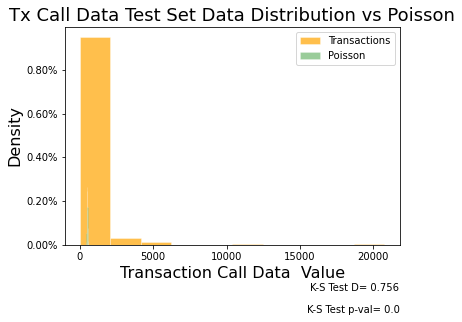

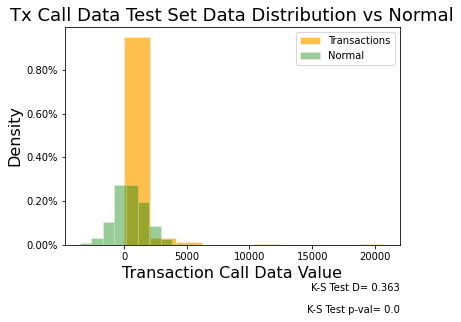

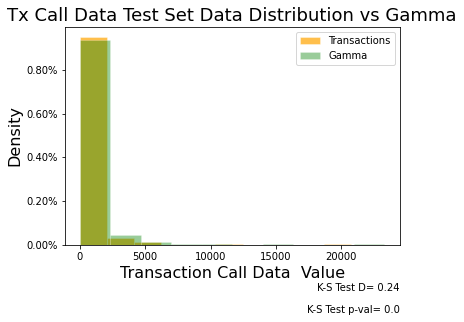

In [6]:
#####  This block fits call data to poisson/normal/gamma, runs K-S tests, and plots histograms  #####

numRVs=np.size(TxCallDataTrain)
poissCallData=stats.poisson.rvs(np.mean(TxCallDataTrain),size=numRVs) #generate poisson points using estimated lambda from Tx data
norCallData=np.random.normal(np.mean(TxCallDataTrain),np.var(TxCallDataTrain)**0.5,numRVs)  #generate poisson points using estimated lambda from Tx data

#MoM estimation of gamma distr:
aCallData=(np.mean(TxCallDataTrain))**2/np.var(TxCallDataTrain)
betaCallData=(np.mean(TxCallDataTrain))/np.var(TxCallDataTrain)
gamCallData=stats.gamma.rvs(aCallData, scale=1/betaCallData,size=numRVs)




fig, ax = plt.subplots()
binNumTxCallData=1000
binNumDistr=100
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxCallDataTest,alpha=0.7,label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxCallDataTest)) / len(TxCallDataTest) )
plt.xlabel('Transaction Call Data  Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Call Data Test Set Data Distribution vs Poisson', fontsize=18)
#ax.set_xscale('log')
ax.hist(poissCallData,label='Poisson', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(poissCallData)) / len(poissCallData) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxCallDataTest, poissCallData)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxCallDataTest, poissCallData)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.legend()
plt.show()


fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxCallDataTest,alpha=0.7, label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxCallDataTest)) / len(TxCallDataTest) )
plt.xlabel('Transaction Call Data Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Call Data Test Set Data Distribution vs Normal', fontsize=18)
#ax.set_xscale('log')
ax.hist(norCallData,label='Normal', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(norCallData)) / len(norCallData) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxCallDataTest, norCallData)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxCallDataTest, norCallData)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
#fig.tight_layout()
ax.legend()
plt.show()


fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.hist(TxCallDataTest,alpha=0.7, label='Transactions', linewidth=0.5, color='orange', edgecolor="white",weights=np.ones(len(TxCallDataTest)) / len(TxCallDataTest) )
plt.xlabel('Transaction Call Data  Value', fontsize=16)
plt.ylabel('Density', fontsize=16)
plt.title('Tx Call Data Test Set Data Distribution vs Gamma', fontsize=18)
#ax.set_xscale('log')
ax.hist(gamCallData,label='Gamma', alpha=0.4, linewidth=0.5, color='g', edgecolor="white",weights=np.ones(len(gamCallData)) / len(gamCallData) )
ax.annotate('K-S Test D= ' + str(round(stats.kstest(TxCallDataTest, gamCallData)[0],3)),xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.annotate('K-S Test p-val= ' + str(round(stats.kstest(TxCallDataTest, gamCallData)[1],5)),xy = (1, -0.3),xycoords='axes fraction',ha='right',va="center",fontsize=10)
ax.legend()
plt.show()



In [164]:
#####  This block generates gas and call data from separate gamma distributions  #####


#Now generate from Tx-gamma:
lenGenerated=10
TxGasGenerated=[]
TxCallDataGenerated=[]
for i in range(lenGenerated):
    TxCallDataGenerated.append(float(stats.gamma.rvs(aCallData, scale=1/betaCallData,size=1))) #must change to break into if statement below to generate diff calldata distr when gas=21k           
    ran=random.uniform(0, 1)
    #ran2=random.uniform(0,1) #dont want to make mixture model for call data with 0s
    if ran<proportionGasLowerLimit:
        TxGasGenerated.append(lowerLimitGas)
    else: 
        TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    #if ran2<proportionCallDataLowerLimit:
    #    TxCallDataGenerated.append(lowerLimitCallData)
    #else: 
    #TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    
print(TxGasGenerated)
print(TxCallDataGenerated)




[16234.484719634494, 305017.12517282687, 385288.05930868495, 2112.6675360141357, 797432.7714563236, 21000, 1505.7898945876043, 21000, 76186.20189811503, 383803.5615164289]
[21.37859344148805, 189.46213289863186, 1.656880259357346, 18.74119957651963, 458.80207355483776, 0.2431322311726857, 3227.0451219373267, 168.68063046350272, 64.84681652523473, 100.60821116976187]


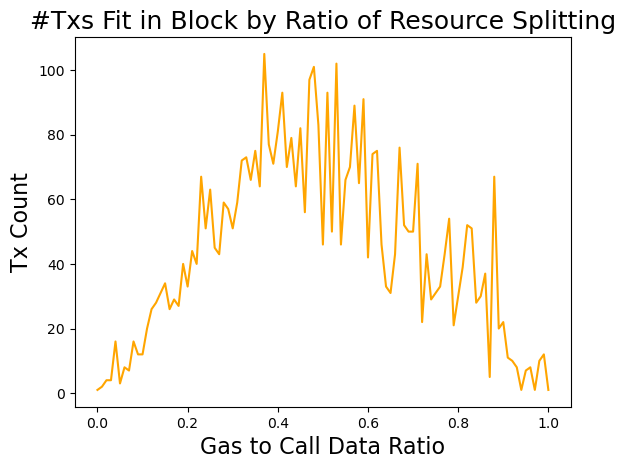

In [165]:
#####  This block generates gas and call data from separate gamma distributions  but now optimize for ratio to see how many Txs fit in total  #####

TxCount=[]
rangeGasRatio=np.linspace(0,1,101)
for i in rangeGasRatio:
    gasMEIPRatio=i #run simulation from 0 to 1 to optimize # Txs per block? or some other metric?
    callDataMEIPRatio=1-gasMEIPRatio
    currentGasLimit=30e6
    mEIPGasLimit=currentGasLimit*gasMEIPRatio #estimate the use of gas to be 2/3 of what calldata will be. How to improve this estimate?
    currentAvgTxPerBlock=round(currentGasLimit/np.mean(TxGasTrain)) #how many Tx we can fit into 30mil gas block
    mEIPCallDataLimit=round(callDataMEIPRatio*currentAvgTxPerBlock*np.mean(TxCallDataTrain)) #how much call data we can fit into block scaled by ratio of current CD to gas 

    TxGasGenerated=[]
    TxCallDataGenerated=[]
    while np.sum(TxGasGenerated)<=mEIPGasLimit and np.sum(TxCallDataGenerated)<=mEIPCallDataLimit:
        TxCallDataGenerated.append(float(stats.gamma.rvs(aCallData, scale=1/betaCallData,size=1)))
        ran=random.uniform(0, 1)
        #ran2=random.uniform(0,1) #dont want to make mixture model for call data with 0s
        if ran<proportionGasLowerLimit:
            TxGasGenerated.append(lowerLimitGas)
        else: 
            TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
        #if ran2<proportionCallDataLowerLimit:
        #    TxCallDataGenerated.append(lowerLimitCallData)
        #else: 
        #TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    TxCount.append(len(TxGasGenerated))


fig, ax = plt.subplots()
ax.plot(rangeGasRatio,TxCount, color='orange')
plt.xlabel('Gas to Call Data Ratio', fontsize=16)
plt.ylabel('Tx Count', fontsize=16)
plt.title('#Txs Fit in Block by Ratio of Resource Splitting', fontsize=18)
plt.show()





In [166]:
gasMEIPRatio=.5 #run simulation from 0 to 1 to optimize # Txs per block? or some other metric?
callDataMEIPRatio=1-gasMEIPRatio
currentGasLimit=30e6
mEIPGasLimit=currentGasLimit*gasMEIPRatio # How to improve this estimate?
currentAvgTxPerBlock=round(currentGasLimit/np.mean(TxGasTrain)) #how many Tx we can fit into 30mil gas block
mEIPCallDataLimit=round(callDataMEIPRatio*currentAvgTxPerBlock*np.mean(TxCallDataTrain)) #how much call data we can fit into block scaled by ratio of current CD to gas 


TxGasGenerated=[]
TxCallDataGenerated=[]
while np.sum(TxGasGenerated)<=mEIPGasLimit and np.sum(TxCallDataGenerated)<=mEIPCallDataLimit:
    TxCallDataGenerated.append(float(stats.gamma.rvs(aCallData, scale=1/betaCallData,size=1)))
    ran=random.uniform(0, 1)
    #ran2=random.uniform(0,1) #dont want to make mixture model for call data with 0s
    if ran<proportionGasLowerLimit:
        TxGasGenerated.append(lowerLimitGas)
    else: 
        TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
    #if ran2<proportionCallDataLowerLimit:
    #    TxCallDataGenerated.append(lowerLimitCallData)
    #else: 
    #TxGasGenerated.append(float(stats.gamma.rvs(aGas, scale=1/betaGas,size=1)))
print(TxCallDataGenerated)
print(TxGasGenerated)
print(len(TxCallDataGenerated))

[0.16429197223010886, 0.02227962770856128, 0.005254341054225303, 0.035853083546890846, 1877.4563820698688, 0.007817026892746333, 0.1986076535117173, 552.618873792044, 0.008620407315880822, 78.57136004043959, 84.27839659530743, 0.012091529278353837, 24.63793906006071, 4.529183887031731e-09, 51.15568804569632, 0.041756996591736456, 46.18656008725045, 46.42976512058168, 359.6652752558549, 2241.5395680589727, 38.61764068240301, 8.502530587640896, 83.87494320522825, 1.1192332214450416, 7449.338814160312, 481.25987047659265, 7.571194755697179e-07, 86.02310703771728, 65.55084767071193, 1146.910695846122, 0.3651827901013739, 1525.5063208780775, 632.1738182638164, 0.04236688621003464, 2260.3590622336915, 54.41378844955222, 8514.181062773656, 69.33700351577522, 96.47061862651454, 9.063129624400958, 0.04512993506635628, 217.30611337298916, 0.0756374286734013, 589.8690463686042, 2.625061014853424, 37.027775168370006, 14.44026882634331, 0.1544507393554349, 0.03560739010899452, 68.44748081513859, 14

In [167]:

#NEXT STEPS: 
#partition 21000 Txs and refit, avoid overfitting with gamma - test/training sets 
        #completed in block 1
#pick best rn bronze standard gamma is good enough now and hten some small work on gamma gamma - sample beta from diff users.
    #put whole story into the hackmd- with the 21000 then without then show how bad poisson and normal are and 
    #then show charts of how good the gmama does
    #include neagtive results too 
        #completed


#barnabe- in the case we aplit gas, we mY and Z are hard to explain but they are probably very correlated. 
#might not need x and y to = z
#longer term:        ppl using rollups are ok with waiting, execution is to go fast
#meip only reduced congestion if strong anticorrelation betwene 2 resources




#joint distribution. actually we do see like 5 clusters. what are their significance? diff call data lengths. am i accidentally using gas limit? not gas used?


######Similar to the high proportion of gas used falling at the lower limit of 21000, we see 23.0% of call data strings with a length of zero. Omitting these,  are we able to improve upon our models.
        #completed - omitting 0 calldata =worse
    
# dont draw from 2 distributions of callData/gas. draw from joint. how to model joint? copula? Cant assume marginals independent
#given 21k gas, genereate CD, rest independence




In [193]:
#toy code: later change this to generate points basaed on a random # generator and if the # generated falls within the ratioBreaks
display(specialGeneration)
nxt=0
ratioBreaks=[]
for i in list(specialGeneration['Ratio of Dataset']):
    ratioBreaks.append(i+np.sum(list(specialGeneration['Ratio of Dataset'])[0:nxt])) 
    nxt=nxt+1
ratioBreaks.append(1)
ratioBreaks.insert(0,0)
print(ratioBreaks)
print(' ')

lenGenerated=10
TxGenerated=[]
for i in range(lenGenerated):
    ran=random.uniform(0, 1)
    print(ran)
    a=0
    while ran <= ratioBreaks[a]:
        print(ratioBreaks[a])
        print('')
        a=a+1


,Gas Value,Call Data Length,Ratio of Dataset,Type
0,21000.0,0.0,0.183000,Point
1,109508.0,8.0,0.023000,Point
2,142361.0,8.0,0.042000,Point
3,90000.0,NaN,0.023000,GasDistribution
4,NaN,0.0,0.046562,CDDistribution
5,NaN,8.0,0.055158,CDDistribution
6,NaN,72.0,0.075931,CDDistribution
7,NaN,136.0,0.227794,CDDistribution
8,NaN,200.0,0.059456,CDDistribution
9,NaN,456.0,0.020057,CDDistribution


[0, 0.183, 0.206, 0.248, 0.271, 0.317561605, 0.3727191985, 0.4486504309, 0.676444131, 0.7358997193, 0.7559570265, 0.7795959955999999, 0.8018022999, 1]
 
0.2704690878213498
0.06280636927376171
0.2140260888378348
0.9806331964168856
0.5638164416397445
0.47550880600859025
0.34084065252584017
0.7597121704754645
0.6891725724353702
0.15562147544947735


For Below Code (improved Tx generation using joint densities):


Ex. For gasVal=90000 , gasValCount=32, the ratio is >2% so add to commonGas list that goes into plot vert line
then loop thru the call data values for 90k. 136, 200, 0, 72, and 8 (CallDataLen values in loop 2). 
need to isolate any CallDataLen that have count (CallDataLenCount) ratios > limit and include them in a model 
that generates them. For example, if gas 90k has lots of callData at len 200, then generate those at the %
they appear in the dataset. then remove from set check if the other callData lengths at same gas value are over limit.


If the count of gas values divided by the total values is over ratioLimitGas (or ratioLimitCallData in separately considered CD values), we will create special conditions to generate points from another joint distribution. This is first used to see if any gas val occurs at least this often in the set. Then if any corresponding cd len value occurs at that gas value over this ratio, we will later generate this exact gas and cd value at the proportion we see it in the set. If the there are other cd values corresponding to the current gas value being evaluated, we check if they all make up a total of over this ratio and generate from a distribution later (using parameters derived from cd lengths at this gas value). Note a limitation of this methodology is that it's possible for a gas value to have a specific CD length over this ratio and the rest of the cd values not summing to over this ratio. Therefore, the current code will not incorporate these points when generating the joint distribution. We repeat this block for CD to find the distributions across various gas values.


Remaining df is filtered by how many different CD values are associated with each gas value (minNumGasValsForDistr variable defines this). the commonDFRemainingGas df is made to define at which gas values we will generate points from using a distribution, while commonDf will generate gas and CD values if that specific combo of gas and CD is common
(more than ratioLimitGas)

Point generation means we generate using a specific CD length and gas value. The leftover CD values can be modeled using a distribution if they don't individually contribute to a large proportion of the dataset.


Status: dfs correctly summarize special cases, so next will take these into account when generating Txs. Must incorporate ratioBreaks from block above to do so.

,Gas Value,Call Data Length,Ratio of Dataset,Type
0,21000.0,0.0,0.183000,Point
1,109508.0,8.0,0.023000,Point
2,142361.0,8.0,0.042000,Point
3,90000.0,NaN,0.023000,GasDistribution
4,NaN,0.0,0.046562,CDDistribution
5,NaN,8.0,0.055158,CDDistribution
6,NaN,72.0,0.075931,CDDistribution
7,NaN,136.0,0.227794,CDDistribution
8,NaN,200.0,0.059456,CDDistribution
9,NaN,456.0,0.020057,CDDistribution


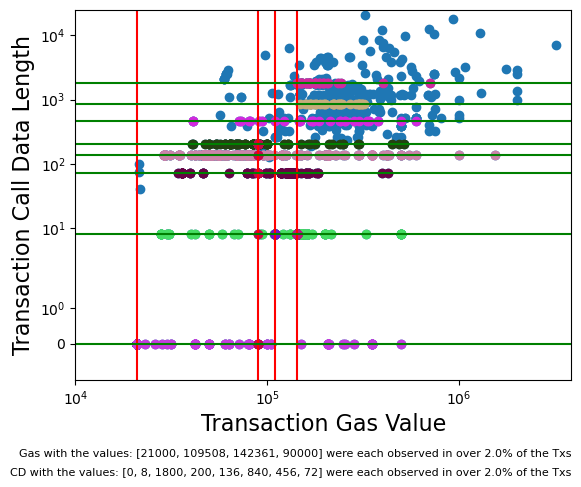

/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Gas Value,Call Data Length,Ratio of Dataset,Type,Alpha Gamma Parameter,Beta Gamma Parameter
0,21000.0,0.0,0.183000,Point,NaN,NaN
1,109508.0,8.0,0.023000,Point,NaN,NaN
2,142361.0,8.0,0.042000,Point,NaN,NaN
3,90000.0,NaN,0.023000,GasDistribution,3.342016,0.023088
4,NaN,0.0,0.046562,CDDistribution,0.427091,0.00001
5,NaN,8.0,0.055158,CDDistribution,3.601112,0.000026
6,NaN,72.0,0.075931,CDDistribution,4.29938,0.000037
7,NaN,136.0,0.227794,CDDistribution,0.654086,0.000006
8,NaN,200.0,0.059456,CDDistribution,1.563451,0.000014
9,NaN,456.0,0.020057,CDDistribution,2.347841,0.000011


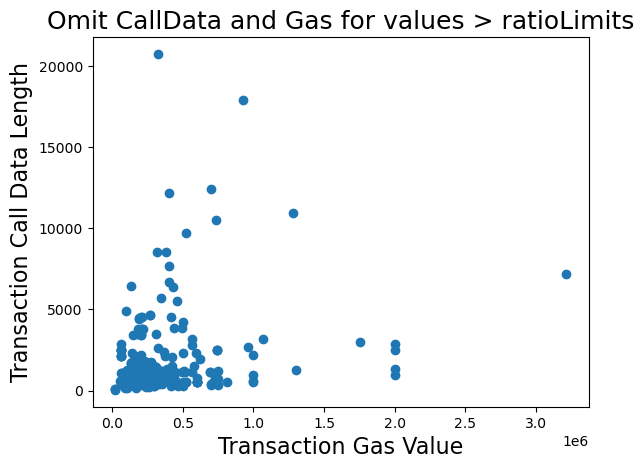

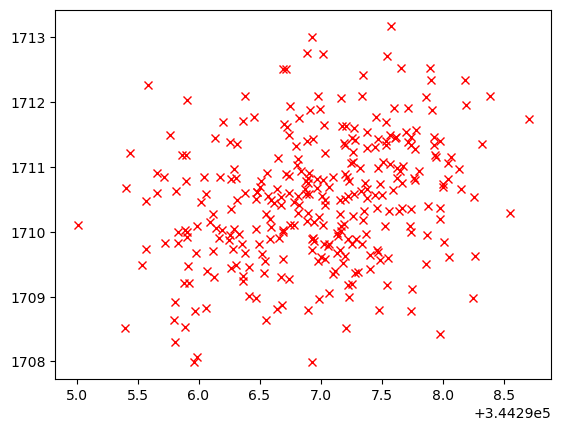

In [311]:
   
#Find most common Gas
ratioLimitGas=0.02 #If the count of gas values divided by the total values is over this ratio, we will create special conditions to generate points from another joint distribution. This is first used to see if any gas val occurs at least this often in the set. Then if any corresponding cd len value occurs at that gas value over this ratio, we will later generate this exact gas and cd value at the proportion we see it in the set. If the there are other cd values corresponding to the current gas value being evaluated, we check if they all make up a total of over this ratio and generate from a distribution later (using parameters derived from cd lengths at this gas value). Note a limitation of this methodology is that it's possible for a gas value to have a specific cd length over this ratio and the rest of the cd values not summing to over this ratio. Therefore, the current code will not incorporate these points when generating the joint distribution.  
ratioLimitCallData=ratioLimitGas
minNumGasValsForDistr=2      #if set to 2 for example, only generates from a distribution if that gas value occurs 3+ times (not including any gas,cd combinations that were at a proportion > the ratio limits)
minNumCallDataValsForDistr=1 #if set to 2 for example, only generates from a distribution if that CD  value occurs 3+ times (not including any gas,cd combinations that were at a proportion > the ratio limits)





commonGas=[]
topGasPoints=[]
topGasDistr=[]
for gasVal,gasValCount in (dict(Counter(df.TxGas)).items()): 
    if gasValCount/len(df) > ratioLimitGas: #if gas value is present in high proportion of dataset
        s=0
        #print('for the gas value of  '+ str(gasVal) + ' the CallData lengths take on '+str(len(list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[:]))+ ' value(s)')
        commonGas.append(gasVal) #used later to make vertical lines in plot
        for CallDataLen,CallDataLenCount in dict(Counter(list(df[df.TxGas==gasVal].TxCallData))).items():
            if CallDataLenCount/len(df) > ratioLimitGas: 
                #print('     for the gas value of  '+ str(gasVal) + ' the CallData of length '+ str(list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[s]) + ' was observed in  ' +str(round(100*CallDataLenCount/len(df),1)) + '% of the dataset')
                topGasPoints.append((gasVal,list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[s],round(CallDataLenCount/len(df),3),len(list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[:])))
            else:
                topGasDistr.append((gasVal,list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[s],round(CallDataLenCount/len(df),3),len(list(Counter(list(df[df['TxGas']==gasVal].TxCallData)).keys())[:])))

            s=s+1

commonDf=pd.DataFrame(topGasPoints,columns=['Gas Value','Call Data Length','Ratio of Dataset','# times in set'])
#display(commonDf) #this is all the gas,cd common points that will be generated at the proportion they appear in the dataset


commonDFRemainingGas=pd.DataFrame(topGasDistr,columns=['Gas Value','Call Data Length','Ratio of Dataset','# times in set'])
vc = commonDFRemainingGas['Gas Value'].value_counts()         
commonDFRemainingGas=commonDFRemainingGas[commonDFRemainingGas['Gas Value'].isin(vc.index[vc.gt(minNumGasValsForDistr)])]

countGasLens=commonDFRemainingGas.groupby('Gas Value').count()['# times in set']
commonDFRemainingGas=commonDFRemainingGas.drop(columns=['# times in set']) #drop column
commonDFRemainingGas=commonDFRemainingGas.groupby(by=["Gas Value"]).sum() 
commonDFRemainingGas['# Corresponding CD Values in Set After Point Generation']=countGasLens
commonDFRemainingGas=commonDFRemainingGas.drop(columns=['Call Data Length']) #drop irrelevant column
commonDFRemainingGas=commonDFRemainingGas[commonDFRemainingGas['Ratio of Dataset'] >=ratioLimitGas] #look at the ratio of the dataset that each gas value encompasses across all CD values

#display(commonDFRemainingGas)



#Find most common cd
commonCallData=[]
#topCallDataPoints=[] #building this df will be the same as topGasPoints so no need to rebuild
topCallDataDistr=[]
for callDataVal,callDataValCount in (dict(Counter(df.TxCallData)).items()): 
    if callDataValCount/len(df) > ratioLimitCallData: #if cd is present in high proportion of dataset
        s=0
        #print('for the CD value of  '+ str(callDataVal) + ' the Gas values take on '+str(len(list(Counter(list(df[df['TxCallData']==callDataVal].TxGas)).keys())[:]))+ ' value(s)')
        commonCallData.append(callDataVal) #used later to make vertical lines in plot
        for gasLen,gasLenCount in dict(Counter(list(df[df.TxCallData==callDataVal].TxGas))).items():
            if gasLenCount/len(df) > ratioLimitCallData: 
                #print('     for the CD value of  '+ str(callDataVal) + ' the CallData of length '+ str(list(Counter(list(df[df['TxCallData']==callDataVal].TxGas)).keys())[s]) + ' was observed in  ' +str(round(100*gasLenCount/len(df),1)) + '% of the dataset')
                continue
                #topCallDataPoints.append((list(Counter(list(df[df['TxCallData']==callDataVal].TxGas)).keys())[s],callDataVal,round(gasLenCount/len(df),3),len(list(Counter(list(df[df['TxCallData']==callDataVal].TxGas)).keys())[:])))
            else:
                topCallDataDistr.append((list(Counter(list(df[df['TxCallData']==callDataVal].TxGas)).keys())[s],callDataVal,round(gasLenCount/len(df),10),     len(list(Counter(list(df[df['TxCallData']==callDataVal].TxGas)).keys())[:])))
            s=s+1

#commonCallDataDf=pd.DataFrame(topCallDataPoints,columns=['Gas Value','Call Data Length','Ratio of Dataset','# times in set']) 
#display(commonCallDataDf)


commonDFRemainingCallData=pd.DataFrame(topCallDataDistr,columns=['Gas Value','Call Data Length','Ratio of Dataset','# times in set'])
vc = commonDFRemainingCallData['Call Data Length'].value_counts()         
commonDFRemainingCallData=commonDFRemainingCallData[commonDFRemainingCallData['Call Data Length'].isin(vc.index[vc.gt(minNumCallDataValsForDistr)])] #This determines how many points needed to estimate distribution parameters. if not enough, no generation occurs.
countCDLens=commonDFRemainingCallData.groupby('Call Data Length').count()['# times in set']
commonDFRemainingCallData=commonDFRemainingCallData.drop(columns=['# times in set']) #drop column
commonDFRemainingCallData=commonDFRemainingCallData.groupby(by=["Call Data Length"]).sum() 
commonDFRemainingCallData['# Corresponding Gas Values in Set After Point Generation']=countCDLens 
commonDFRemainingCallData=commonDFRemainingCallData.drop(columns=['Gas Value']) #drop irrelevant column
#commonDFRemainingCallData=commonDFRemainingCallData.rename(columns={"# times in set": "# Times CD Appears in Set After Point Generation"}) 
commonDFRemainingCallData=commonDFRemainingCallData[commonDFRemainingCallData['Ratio of Dataset'] >=ratioLimitCallData] #look at the ratio of the dataset that each cd value encompasses across all gas values

#display(commonDFRemainingCallData)


#Now merge DFs together that identify gas,cd points for special Tx generation as well as individual gas and cd values that will have distributions fit and generated randomly from them
commonDf['Type'] = 'Point'#this is all the gas,cd common points that will be generated at the proportion they appear in the dataset
commonDFRemainingGas['Type'] = 'GasDistribution'
commonDFRemainingCallData['Type'] = 'CDDistribution'

tempDf=commonDf.merge(commonDFRemainingGas, how='outer', on=['Gas Value','Ratio of Dataset','Type'])
specialGeneration=tempDf.merge(commonDFRemainingCallData, how='outer', on=['Call Data Length','Ratio of Dataset','Type']).drop(columns=['# times in set','# Corresponding CD Values in Set After Point Generation','# Corresponding Gas Values in Set After Point Generation'])
display(specialGeneration)


#Create plots of CD vs Gas
fig, ax = plt.subplots()
ax.scatter(df['TxGas'],df['TxCallData'])
ax.set_xscale('symlog')
ax.set_yscale('symlog')

from random import randint
colors = []
for i in range(len(commonCallData)):
    random.seed(i*22)
    colors.append('#%06X' % randint(0, 0xFFFFFF))
    
ss=0
for i in commonCallData:
    ax.scatter(df[df['TxCallData']==i].TxGas,df[df['TxCallData']==i].TxCallData,color=colors[ss])
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ss=ss+1

colors2 = []   
for i in range(len(commonGas)):
    random.seed(i*8)
    colors2.append('#%06X' % randint(0, 0xFFFFFF))

sss=0
for i in commonGas:
    ax.scatter(df[df['TxGas']==i].TxGas,df[df['TxGas']==i].TxCallData,color=colors2[sss])
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    sss=sss+1
    
for i in range(len(commonGas)):
    plt.axvline(x=commonGas[i],color='r')    
for i in range(len(commonCallData)):
    plt.axhline(y=commonCallData[i],color='g')    

ax.annotate('Gas with the values: '+str(commonGas)+' were each observed in over '+str(100*ratioLimitGas)+'% of the Txs',xy = (1, -0.2),xycoords='axes fraction',ha='right',va="center",fontsize=8)
ax.annotate('CD with the values: '+str(commonCallData)+' were each observed in over '+str(100*ratioLimitCallData)+'% of the Txs',xy = (1, -0.25),xycoords='axes fraction',ha='right',va="center",fontsize=8)
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Transaction Call Data Length', fontsize=16)
plt.xlim([1e4, np.max(df.TxGas)*1.2])
plt.ylim([-1, np.max(df.TxCallData)*1.2])

plt.show()




#Now find gamma parameters for clusters:

specialGeneration['Alpha Gamma Parameter']='NaN'
specialGeneration['Beta Gamma Parameter']='NaN'


for i in range(len(specialGeneration)): 
    if specialGeneration['Type'].loc[i]=='GasDistribution':
        specialGeneration['Alpha Gamma Parameter'].loc[i]=(np.mean(  df[df.TxGas==specialGeneration['Gas Value'][i]].TxCallData   ))**2/np.var( df[df.TxGas==specialGeneration['Gas Value'][i]].TxCallData   )
        specialGeneration['Beta Gamma Parameter'].loc[i]= (np.mean(  df[df.TxGas==specialGeneration['Gas Value'][i]].TxCallData   ))/np.var( df[df.TxGas==specialGeneration['Gas Value'][i]].TxCallData   )
    if specialGeneration['Type'].loc[i]=='CDDistribution':
        specialGeneration['Alpha Gamma Parameter'].loc[i]=(np.mean(  df[df.TxCallData==specialGeneration['Call Data Length'][i]].TxGas   ))**2/np.var( df[df.TxCallData==specialGeneration['Call Data Length'][i]].TxGas   )
        specialGeneration['Beta Gamma Parameter'].loc[i]= (np.mean(  df[df.TxCallData==specialGeneration['Call Data Length'][i]].TxGas   ))/np.var( df[df.TxCallData==specialGeneration['Call Data Length'][i]].TxGas   )
        
        
display(specialGeneration)


#the below generates based on proportions of dataset they encompass. improve by generating ran# and seeing which ratioBreak it falls into. Same outcome below though.
lenGenerated=1000
TxGenerated=[] # (gas,CD)
dfRemaining=df

for i in range(len(specialGeneration)): 
    if specialGeneration['Type'].loc[i]=='GasDistribution':
        dfRemaining=dfRemaining.drop(dfRemaining[dfRemaining.TxGas == specialGeneration['Gas Value'][i]].index)
        TxGenerated=TxGenerated+(  list(zip( [specialGeneration['Gas Value'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i])    ,            list(stats.gamma.rvs(specialGeneration['Alpha Gamma Parameter'].loc[i], scale=1/specialGeneration['Beta Gamma Parameter'].loc[i],size=round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) ))))     )
    if specialGeneration['Type'].loc[i]=='CDDistribution':
        dfRemaining=dfRemaining.drop(dfRemaining[dfRemaining.TxCallData == specialGeneration['Call Data Length'][i]].index)
        TxGenerated=TxGenerated+(  list(zip(    list(stats.gamma.rvs(specialGeneration['Alpha Gamma Parameter'].loc[i], scale=1/specialGeneration['Beta Gamma Parameter'].loc[i],size=round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) )), [specialGeneration['Call Data Length'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) ))     )
    if specialGeneration['Type'].loc[i]=='Point':
        dfRemaining=dfRemaining.drop(dfRemaining[(dfRemaining.TxCallData == specialGeneration['Call Data Length'][i]) & (dfRemaining.TxGas == specialGeneration['Gas Value'][i])].index)
        TxGenerated=TxGenerated+(  list(zip(    [specialGeneration['Gas Value'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i])   ,                         [specialGeneration['Call Data Length'][i]]*round(lenGenerated*specialGeneration['Ratio of Dataset'].loc[i]) )))
remainingLength=lenGenerated-round(np.sum(lenGenerated*specialGeneration['Ratio of Dataset']) )
#TxGenerated=TxGenerated+   #need to include dfRemaining generation. first see how well it follows lognormal









fig, ax = plt.subplots()
ax.scatter(dfRemaining['TxGas'],dfRemaining['TxCallData'])
#ax.set_xscale('symlog')
#ax.set_yscale('symlog')
plt.title('Omit CallData and Gas for values > ratioLimits', fontsize=18)
plt.xlabel('Transaction Gas Value', fontsize=16)
plt.ylabel('Transaction Call Data Length', fontsize=16)
plt.show()


#Try to model the bulk of the data
logCovMat=np.cov(np.log(dfRemaining['TxGas']),np.log(dfRemaining['TxCallData']))
logMuGas=(np.mean(dfRemaining['TxGas']))
logMuCallData=(np.mean(dfRemaining['TxCallData']))

x, y = np.random.multivariate_normal([logMuGas,logMuCallData], logCovMat, len(dfRemaining['TxGas'])).T
plt.plot(x, y, 'x',color='r');

#model this in TxGenerated as 2D lognormal
